# DLSP25U: Introduction to Deep Learning

**Name:** Sara Vargas


**Instructions:**

In this notebook, you will be asked to write code and answer questions.  
Place all responses under the **Solution** headers or directly in the code.

---

This fourth assignment is aimed at training fully connected neural networks and understanding their behaviour.

In [291]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 31

np.random.seed(SEED)

## Cloning the micrograd repo

Before we start, we need to clone the micrograd repository. This repository contains the original code for the micrograd library, which we will use to build our neural network. 

In order to do so you need install the micrograd package by running the following cell

In [292]:
!pip install micrograd


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## 1. Missing Ingredients

The original implementation of the Micrograd library by Andrej Karpathy is missing some important components that we need to build a neural network. In this first exercise you are asked to implement these components. Some of them have already been introduced in the lectures, while others are new.

### Functions and operators

The components you should already be familiar with are:

- Exponential: $\exp (x)$ 
- Logarithm: $\log(x)$
- Sigmoid: $\sigma(x) = (1 + \exp (-x))^{-1}$

These components were introduced to solve the **Linear Regression** and **Binary Classification** problems. Below is a new class, `Value`, derived from the original one, in which you are asked to implement these missing methods.

Additionally you will implement the following components as methods of the `Value` class:

- Softplus: $\log(1 + e^x)$

Then, externally to the `Value` class, you will implement the following functions:

- Softmax: $\text{softmax}(\boldsymbol{x}) = \sum_i \exp(x_i)$
- Softargmax: $\text{softargmax}(\boldsymbol{x}) = \frac{\exp(\boldsymbol{x})}{\sum_i \exp(x_i)}$

In [354]:
import numpy as np
from micrograd.engine import Value as OldValue

class Value(OldValue):
    def __init__(self, data, _children=(),_op=''):
        super().__init__(data, _children, _op)
    def exp(self):
        x = self.data
        out = Value(np.exp(x))
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        out._prev = (self,)
        return out
    
    def log(self):
        x = self.data
        out = Value(np.log(x))
        
        def _backward():
            self.grad += (1.0 / x) * out.grad
        
        out._backward = _backward
        out._prev = (self,)
        return out
    
    def sigmoid(self):
        x = self.data
        s = 1 / (1 + np.exp(-x))
        out = Value(s)
        
        def _backward():
            self.grad += (s * (1 - s)) * out.grad
        
        out._backward = _backward
        out._prev = (self,)
        return out

    def softplus(self):
        x = self.data
        out_val = np.log(1 + np.exp(x))
        out = Value(out_val)
        
        def _backward():
            sigmoid_x = 1 / (1 + np.exp(-x))
            self.grad += sigmoid_x * out.grad
        
        out._backward = _backward
        out._prev = (self,)
        return out


In [355]:
def softmax(x_list):
    return np.sum( np.exp(i) for i in x_list )

def softargmax(x_list):
    return np.exp(x_list)/softmax(x_list)

**WARNING**

*The following cell must not be modified and should be run only after implementing the `Value` class. Removing or altering this cell may cause issues, as subsequent cells depend on this class implementation.*

In [356]:
OldValue.__new__ = staticmethod(lambda *args, **kwargs: object.__new__(Value))

### Loss functions

Additionally, we would like to define some loss functions that are commonly used in neural networks. These are:

- Mean Squared Error:
    $$L_{\text{MSE}}(\boldsymbol{w}, x, y) = (y - \boldsymbol{w}^\top \boldsymbol{f}(x))^2$$
- Binary Cross Entropy:
$$L_{\text{BCE}}(\boldsymbol{w}, x, y) = - y_n \log( \boldsymbol{w}^\top \boldsymbol{f}(x) ) - (1 - y_n) \log(1 - \boldsymbol{w}^\top \boldsymbol{f}(x) )$$
- Binary Cross Entropy with Softplus:
$$
\begin{align*}
L_{\text{BCE-SP}}(\boldsymbol{w}, x, y) &= y \: \text{softplus}(-\boldsymbol{w}^\top \boldsymbol{f}(x)) + (1-y) \: \text{softplus}(\boldsymbol{w}^\top \boldsymbol{f}(x)) \\
&= \text{softplus}( -y' \boldsymbol{w}^\top \boldsymbol{f}(x)), \quad \text{where} \:\quad y' = 2y - 1
\end{align*}
$$
- (Multiclass) Cross Entropy:
$$
\begin{align*}
L_{\text{CE}}(\boldsymbol{w},x,y) &= \log \sum_{k=1}^{K} \exp(\boldsymbol{w}_k^{\top} \boldsymbol{f}(x)) -\boldsymbol{w}_y^{\top} \boldsymbol{f}(x) \\
&= \text{softmax}(\boldsymbol{W} \boldsymbol{f}(x)) -\boldsymbol{w}_y^{\top} \boldsymbol{f}(x)
\end{align*}
$$

In order to do so, please implement the following methods in the `Loss` class:

- `mse`
- `bce`
- `bce_sp`
- `ce`

In practice, the `bce_sp` loss function is preferred over `bce` due to its greater numerical stability. You are therefore encouraged to use `bce_sp` in the following exercises.

In [357]:
class Loss:

    def __init__(self, loss_function):
        self.loss_function = loss_function

    def __call__(self, y, y_pred):
        return self.global_loss(y, y_pred)

    def sample_loss(self, y, y_pred):
        y = Value(y) if not isinstance(y, Value) else y
        y_pred = Value(y_pred) if not isinstance(y_pred, Value) else y_pred
        return self.loss_function(y, y_pred)

    def global_loss(self, Y, Y_pred):
        N = len(Y)
        losses = [ self.sample_loss(y, y_pred) for y, y_pred in zip(Y, Y_pred) ]
        return sum(losses) / N

    @staticmethod
    def mse(y, y_pred):
        return np.pow( (y-y_pred), 2)
    
    @staticmethod
    def bce(y, y_pred):
        return -y* np.log(y_pred)- (1-y)*(1-np.log(y_pred))
    
    @staticmethod
    def bce_sp(y, y_pred):
        y2= 2*y-1
        wtf= Value(-y2 * y_pred)

        softplus= wtf.softplus()
        return softplus
    
    @staticmethod
    def ce(y, y_pred):
        return softmax(y_pred-y)

        
        

#### Brief explanation of the `Loss` class

Each *per-sample* loss function is implemented as a static method of the class. To create an instance of the class, you need to pass the *per-sample* loss function as an argument to the constructor. 

```python
loss = Loss(Loss.mse)
```

The `global_loss` method is used to compute the average loss over all samples. Invoking the object directly, as defined in `__call__`, will compute the *global* loss.

```python
loss = Loss(Loss.mse)
global_loss_value = loss(Y, Y_pred)
```

## 2. Regression

Now that we have all the necessary components, we start by implementing a neural network for regression. The goal is to approximate the following functions:

- $y=x^2$
- $y=\sin(x)$

For each function:

- Generate 400 samples in the range $[-5, 5]$, then add some Gaussian noise using the `np.random.normal` function with zero mean, $\mu=0$, and a standard deviation of $\sigma = 0.3$. This is your training set. Repeat the process for the test set.
<!-- $$
\begin{align*}
    \mathcal{D} &= \{ (x_i, y_i) \mid x_i \in [-5, 5] \cap \mathbb{R}, y_i = f(x_i) + \varepsilon_i \} \\
    \varepsilon_i &\sim \mathcal{N}(0, 0.3)
\end{align*}
$$ -->

- Use the a fully connected neural network (unfortunately named `MLP` by Karpathy) with the ReLU activation function. Train the network until convergence or until you find the performance satisfactory. After training, plot the loss evolution and analyze it. Does the loss always decrease in the same manner? Consider whether different regimes appear while the loss is decreasing.
**Tip**: *If so, save the model at the epoch where the learning behavior changes and plot the predictions against the ground truth. This will help you better understand what is happening.*

- Using the trained model, compute the predictions for both the training set and test set and compute the loss. Then plot the predictions against the ground truth for the test set.

In this exercise, you are free to experiment by varying both the number of hidden layers and the number of neurons in each layer. Choose the architecture that you think better approximates the functions keeping in mind that, because the library is not optimized, training may take a long time.

---

### **Some Tips on the `MLP` Class by Karpathy**

The `MLP` class is a simple implementation of a fully connected neural network, often incorrectly referred to as a Multi-Layer Perceptron (MLP), since perceptrons use the heavisde activation function, which derivative is zero almost everywhere.

The constructor of the `MLP` class takes two inputs:
- `nin`: the number of input neurons
- `nouts`: a list specifying the number of neurons in each hidden layer and the output layer.

If you want to create a network with an input dimension of 3, two hidden layers of 10 neurons each, and an output layer of 1 neuron, you should instantiate the class as follows:

```python
net = MLP(3, [10, 10, 1])
```

Moreover, the `__call__` method of the class takes the input data and returns the network's output (the prediction). It expects the input data to be a list of either `Value` objects or numbers.
As a consequence, even if your inputs has dimension 1, you should still pass it as a list with just one item:

```python
x = [2.0]
ỹ = net(x)
```

If your input dimension is 2 and you have 3 data points, computing the predictions will look like this:

```python
X = [
    [Value(1.0), Value(2.0)],
    [Value(3.0), Value(4.0)],
    [Value(5.0), Value(6.0)]
]
Ỹ = [net(x) for x in X]
```

Finally, the type of the output depends on the output size: if the output size is 1, the output will just be a `Value` object, if the output size is greater than 1, the output will be a list of `Value` objects.

---


### How to **Train** Your Neural Network

Before training the neural network, some training *hyperparameters* must be defined. In our case, these are:

- Which optimizer to use. In this case, we will use the **Stochastic Gradient Descent (SGD)** optimizer.
    SGD updates the parameters using the gradient computed from *a single sample*. This makes it much faster and often better for generalization, but the updates are noisier. Noisy updates can help the algorithm escape local minima.

    Example in Python:
    ```python
    # Stochastic Gradient Descent (SGD)
    for epoch in range(n_epochs):
        for x, y in zip(X, Y):  # Iterate over individual samples
            y_pred = model([Value(xi) for xi in x])
            loss_val = loss(y, y_pred)
            model.zero_grad()
            loss_val.backward()
            for p in model.parameters():
                p.data -= learning_rate * p.grad.data
    ```

- `learning_rate`: the step size of the gradient descent algorithm.  
- `n_epochs`: the number of epochs, i.e., the number of times the network will see the entire dataset.

The process of training a neural network can be summarized as follows:

- **Forward Pass**:
    Compute the output of the network given the input data:
    ```python
        y_pred = model([xi for xi in x])
    ```
- **Loss Computation**:
    Compute the loss function:
    ```python
       loss_value = loss(y, y_pred)
    ```

- **Zero out the gradients**:
    Before computing the gradients, it is necessary to zero out the gradients of the parameters:
    ```python
        model.zero_grad()
    ```

- **Backward Pass**
    Compute the gradients of the loss function with respect to the parameters:
    ```python
        loss_value.backward()
    ```

- **Optimizer Step**
    Update the parameters using the gradients:
    ```python
        for p in model.parameters():
            p.data -= learning_rate * p.grad.data
    ```


In [358]:
from micrograd.nn import MLP as FCNN
#from micrograd.engine import Value

### 2.1 $y=x^2$

In [359]:
g = lambda x: x**2

#### Data Generation

In [360]:
#making test and training set: 
X_train = np.random.uniform(-5, 5, size=(400, 1))
y_train = g(X_train) + np.random.normal(0, 0.3, X_train.shape)

X_test = np.random.uniform(-5, 5, size=(400, 1))
y_test = g(X_test) + np.random.normal(0, 0.3, X_test.shape)


#### Training

I noticed tweaking the learning rate as well as the neurons in the hidden layer and the epoch number was very important to obtain a reasonale output. I had to make sure the model didnt over shoot if (the learning rate wasnt to big). 

Epoch 1/100 - Loss: 160.2834
Epoch 11/100 - Loss: 11.0298
Epoch 21/100 - Loss: 10.2906
Epoch 31/100 - Loss: 14.5477
Epoch 41/100 - Loss: 20.5254
Epoch 51/100 - Loss: 17.6898
Epoch 61/100 - Loss: 16.7628
Epoch 71/100 - Loss: 16.0988
Epoch 81/100 - Loss: 15.3486
Epoch 91/100 - Loss: 14.5122
Epoch 100/100 - Loss: 8.5987


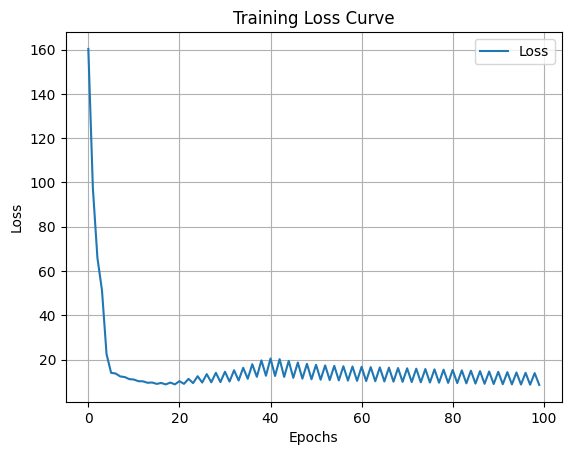

In [361]:
import numpy as np
import matplotlib.pyplot as plt


g = lambda : x**2

def mse_loss(y_true, y_pred):
    return (y_pred - y_true) ** 2 

# hyperparameters
learning_rate = 0.03
n_epochs = 100
losses = []

model = FCNN(1, [4, 1]) 
X = [[Value(float(x))] for x in X_train.ravel()]
Y = [Value(float(y)) for y in y_train.ravel()]

for epoch in range(n_epochs):
    epoch_loss = Value(0)
    for x, y in zip(X, Y):
        y_pred = model(x)
        loss_val = mse_loss(y, y_pred)
        epoch_loss += loss_val

    avg_loss = epoch_loss / len(X)
    losses.append(avg_loss.data)

    model.zero_grad()
    avg_loss.backward()
    
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {float(avg_loss.data):.4f}")

        
plt.plot(range(n_epochs), losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()






#### Prediction

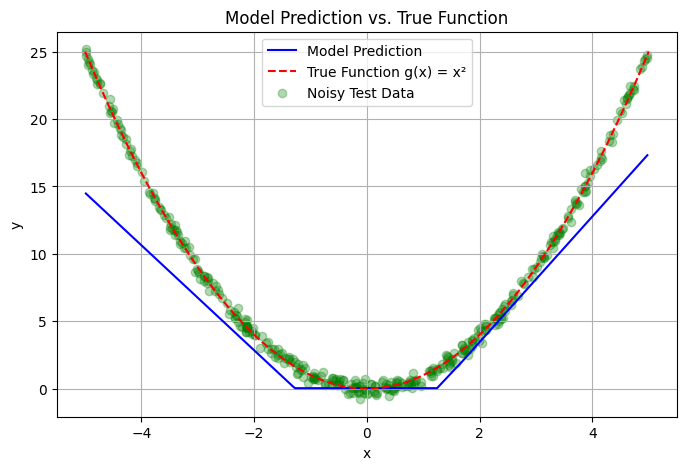

In [362]:
X_test_vals = [[Value(float(x))] for x in X_test.ravel()]

y_pred_vals = [model(x).data for x in X_test_vals]

sorted_pairs = sorted(zip(X_test.ravel(), y_pred_vals))
X_sorted, y_pred_sorted = zip(*sorted_pairs)

X_plot = np.linspace(-5, 5, 400).reshape(-1, 1)
y_true = X_plot ** 2 

plt.figure(figsize=(8, 5))
plt.plot(X_sorted, y_pred_sorted, label="Model Prediction", color='blue')
plt.plot(X_plot, y_true, label="True Function g(x) = x²", color='red', linestyle='dashed')
plt.scatter(X_test, y_test, color='green', alpha=0.3, label="Noisy Test Data")
plt.title("Model Prediction vs. True Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### 2.2 $y=\sin(x)$

In [363]:
g = lambda x: np.sin(x)

#### Data Generation

In [364]:
#making test and training set: 
X_train = np.random.uniform(-5, 5, size=(400, 1))
y_train = g(X_train) + np.random.normal(0, 0.3, X_train.shape)

X_test = np.random.uniform(-5, 5, size=(400, 1))
y_test = g(X_test) + np.random.normal(0, 0.3, X_test.shape)


#### Training

Epoch 1/100 - Loss: 2.2381
Epoch 11/100 - Loss: 0.5728
Epoch 21/100 - Loss: 0.5040
Epoch 31/100 - Loss: 0.4505
Epoch 41/100 - Loss: 0.4072
Epoch 51/100 - Loss: 0.3700
Epoch 61/100 - Loss: 0.3373
Epoch 71/100 - Loss: 0.3083
Epoch 81/100 - Loss: 0.2826
Epoch 91/100 - Loss: 0.2600
Epoch 100/100 - Loss: 0.2419


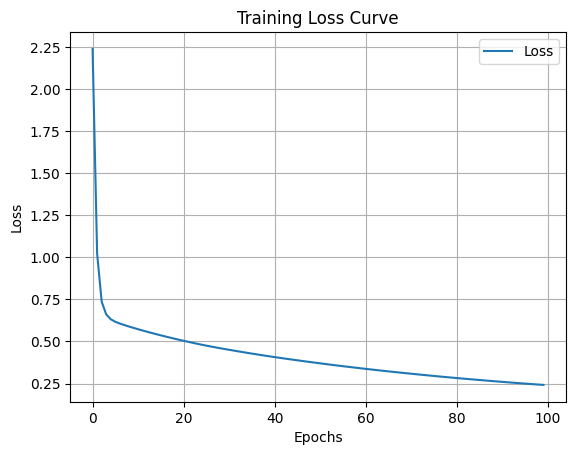

In [365]:
import numpy as np
import matplotlib.pyplot as plt


g = lambda x: np.sin(x)
def mse_loss(y_true, y_pred):
    return (y_pred - y_true) ** 2 

# hyperparameters
learning_rate = 0.03
n_epochs = 100
losses = []

model = FCNN(1, [12, 1]) 
X = [[Value(float(x))] for x in X_train.ravel()]
Y = [Value(float(y)) for y in y_train.ravel()]

for epoch in range(n_epochs):
    epoch_loss = Value(0)
    for x, y in zip(X, Y):
        y_pred = model(x)
        loss_val = mse_loss(y, y_pred)
        epoch_loss += loss_val

    avg_loss = epoch_loss / len(X)
    losses.append(avg_loss.data)

    model.zero_grad()
    avg_loss.backward()
    
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {float(avg_loss.data):.4f}")

        
   
plt.plot(range(n_epochs), losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()






#### Prediction

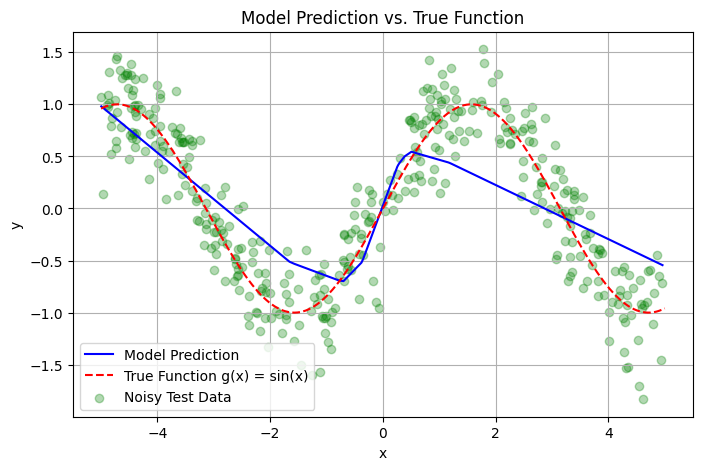

In [366]:

X_test_vals = [Value(xj) for xj in X_test]

y_pred_vals = [model([xi]).data for xi in X_test_vals]


sorted_pairs = sorted(zip(X_test.flatten(), y_pred_vals))
X_sorted, y_pred_sorted = zip(*sorted_pairs)

X_plot = np.linspace(-5, 5, 400).reshape(-1, 1)
y_true = g(X_plot)

plt.figure(figsize=(8, 5))
plt.plot(X_sorted, y_pred_sorted, label="Model Prediction", color='blue')
plt.plot(X_plot, y_true, label="True Function g(x) = sin(x)", color='red', linestyle='dashed')
plt.scatter(X_test, y_test, color='green', alpha=0.3, label="Noisy Test Data")
plt.title("Model Prediction vs. True Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

## Binary Classification

In the second task you are asked to complete is to implement a neural network for binary classification on a non-linearly separable dataset.

### Dataset Generation

The first step is to generate a dataset. We will use the `make_moons` function from the `sklearn.datasets` module to generate a dataset with two classes. You should generate 300 samples with a noise parameter of 0.1. Then plot the dataset using the `matplotlib` library.

In [367]:
from sklearn.datasets import make_moons

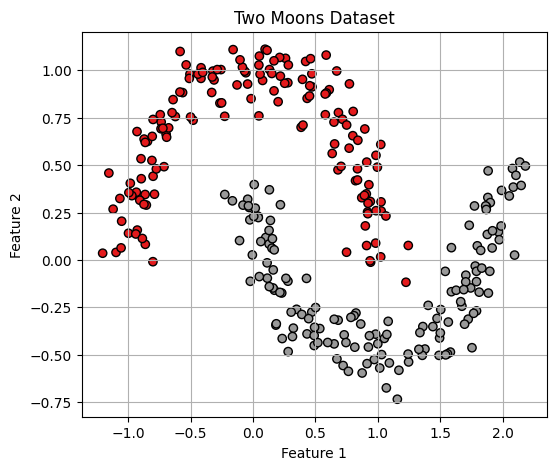

In [373]:

X_moon, y_moon = make_moons(n_samples=300, noise=0.1)

plt.figure(figsize=(6, 5))
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap=plt.cm.Set1, edgecolor='k')
plt.title("Two Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


### Model Definition

Next, you should define a Fully Connected Neural Network to perform the binary classification. You are free to choose the number of hidden layers and neurons in each layer. Be aware that this implementation is not optimized for performance, so you should keep the number of neurons and layers small while achieving decent performance.

In [374]:
from micrograd.nn import MLP as FCNN

In [375]:
model = FCNN(2, [4, 4, 1])


### Training

Now it is time to train the model. You should train the model until it converges or until a decent performance is reached. Use an appropriate loss function using the `Loss` class. Save the loss values in a list, we will use them later. 

In [402]:
X_vals = [[Value(x1), Value(x2)] for x1, x2 in X_moon]
y_vals = [Value(float(yi)) for yi in y_moon]

loss = Loss(Loss.bce)

learning_rate = 0.1
n_epochs = 50
losses = []

for epoch in range(n_epochs):
    epoch_loss = Value(0)

    for x, y in zip(X_vals, y_vals):
        y_raw = model(x)
        y_pred = y_raw.sigmoid()
       
        loss_val = -(y * y_pred.log() + (1 - y) * (1 - y_pred).log())

        epoch_loss += loss_val

    avg_loss = epoch_loss / len(X_vals)
    losses.append(avg_loss.data)


    model.zero_grad()
    avg_loss.backward()
    
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    
    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss.data:.4f}")


Epoch 1/50 - Loss: 0.2036
Epoch 11/50 - Loss: 0.1999
Epoch 21/50 - Loss: 0.1960
Epoch 31/50 - Loss: 0.1917
Epoch 41/50 - Loss: 0.1874
Epoch 50/50 - Loss: 0.1836


### Evaluation

In this last part we want to evaluate how the loss changed during the training process and how is the performance of the model we obtained.

- Plot the loss evolution during the training process
- Print the loss value achieved at the end of the training process
- Compute the accuracy of the model on the training set
- Plot the predictions of the model on the training set. Do they resemble the dataset?
- On the same plot, plot the decision boundary of the model.

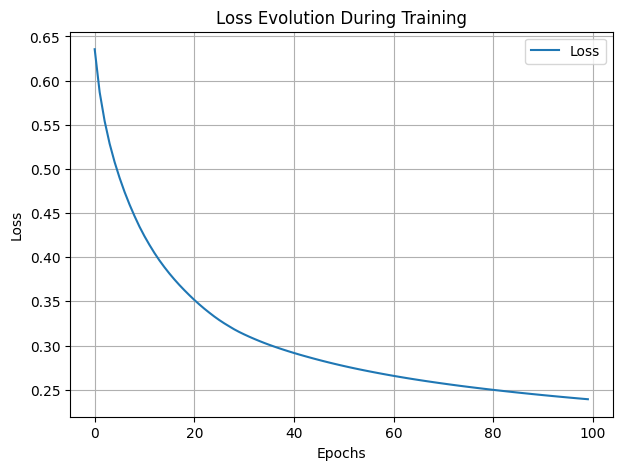

Final loss: 0.2392
Training Accuracy: 66.75%


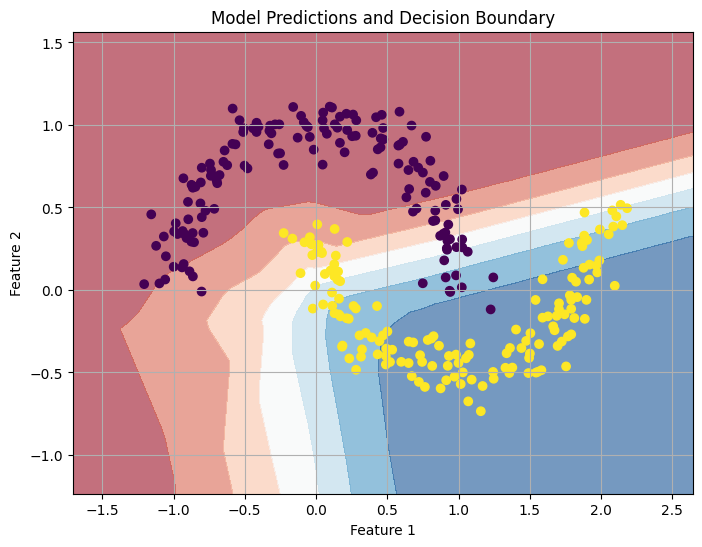

In [400]:
import matplotlib.pyplot as plt
import numpy as np



plt.figure(figsize=(7, 5))
plt.plot(range(len(losses)), losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Evolution During Training")
plt.legend()
plt.grid(True)
plt.show()


print(f"Final loss: {losses[-1]:.4f}")

correct = 0
for xi, yi in zip(X_moon, y_moon):
        x_val = [Value(xi[0]), Value(xi[1])]
        y_pred = model(x_val)
        y_prob = 1 / (1 + (-y_pred).exp())  
        pred_class = 1 if y_prob.data >= 0.5 else 0
        if pred_class == yi:
            correct += 1
acc = correct / len(y_true)
print(f"Training Accuracy: {acc * 100:.2f}%")
   

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),np.arange(y_min, y_max, 0.05))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = []
    
    for point in grid:
        val_input = [Value(point[0]), Value(point[1])]
        out = model(val_input)
        prob = 1 / (1 + (-out).exp())
        Z.append(prob.data)
    Z = np.array(Z).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Model Predictions and Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    
    plt.show()

plot_decision_boundary(model, X_moon, y_moon)
